In [176]:
## Importing all required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

## Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

## Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Step 1: Reading and Understanding the Data

In [177]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [178]:
housing = pd.read_csv("/content/gdrive/My Drive/MS/train.csv", encoding = "ISO-8859-1", low_memory=False)
#housing = pd.read_csv("train.csv", encoding = "ISO-8859-1", low_memory=False)

In [179]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [180]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [181]:
housing.shape

(1460, 81)

In [182]:
housing.isnull().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 81, dtype: bool

In [183]:
housing.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Step 2: Data Cleaning

In [184]:
## check for null values in all categorical columns in the data

housing.select_dtypes(include='object').isnull().sum()[housing.select_dtypes(include='object').isnull().sum()>0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [185]:
## Replace NA with None in the below columns

for col in ('Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'):
    
    housing[col]=housing[col].fillna('None')

In [186]:
## Drop the following columns that have more than 85% values associated to a specific value

## Method to get the column names that have count of one value more than 85%

def getHighCategoricalValues():
    column = []
    categorical_columns = housing.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(housing[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighCategoricalValues()

## Remove the columns with skewed data

housing.drop(columnsToBeRemoved, axis = 1, inplace = True)

housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003.0,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976.0,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001.0,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998.0,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000.0,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000


In [187]:
housing.select_dtypes(include='object').isnull().sum()[housing.select_dtypes(include='object').isnull().sum()>0]


Series([], dtype: int64)

In [188]:
## Removing null values in Numerical attributes

## check the null values in the numerical data

housing.select_dtypes(include=['int64','float']).isnull().sum()[housing.select_dtypes(include=['int64','float']).isnull().sum()>0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [189]:
## Impute the null values with median values for LotFrontage and MasVnrArea columns

housing['LotFrontage'] = housing['LotFrontage'].replace(np.nan, housing['LotFrontage'].median())
housing['MasVnrArea'] = housing['MasVnrArea'].replace(np.nan, housing['MasVnrArea'].median())

In [190]:
## Setting the null values with 0 for GarageYrBlt for now as we would be handling this column further below

housing['GarageYrBlt']=housing['GarageYrBlt'].fillna(0)
housing['GarageYrBlt'] = housing['GarageYrBlt'].astype(int)

In [191]:
## Create a new column named IsRemodelled - This column would determine whether the house has been remodelled or not based on the difference between remodelled and built years

def checkForRemodel(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
housing['IsRemodelled'] = housing.apply(checkForRemodel, axis=1)
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,IsRemodelled
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,0
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,1
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,0


In [192]:
## Create a new column named BuiltOrRemodelledAge and determine the age of the building at the time of selling

def getBuiltOrRemodelAge(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
       
housing['BuiltOrRemodelAge'] = housing.apply(getBuiltOrRemodelAge, axis=1)
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,IsRemodelled,BuiltOrRemodelAge
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,0,5
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0,31
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1,6
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,1,36
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,0,8


In [193]:
## Create a new column which would indicate if the Garage is old or new.
## Garage Yr Built less than 2000 will be considered as old (0) else new(1). 
## For GarageYrBuilt , where we have imputed the value as 0 will also be treated as old.

def getGarageConstructionPeriod(row):
    if row == 0:
        return 0
    elif row >= 1900 and row < 2000:        
        return 0
    else:   
        return 1
    
housing['OldOrNewGarage'] = housing['GarageYrBlt'].apply(getGarageConstructionPeriod)
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,0,5,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0,31,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1,6,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,1,36,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,0,8,1


In [194]:
## Since we have created new features from YearBuilt, YearRemodAdd, YrSold and GarageYrBlt, we can drop these columns as we 
## would only be using the derived columns for further analysis

housing.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace = True)

In [195]:
## Drop the following columns that have more than 85% values associated to a specific value
## We will also drop MoSold as we will not be using that for further analysis

def getHighNumericalValues():
    column = []
    numerical_columns = housing.select_dtypes(include=['int64', 'float'])
    for col in (numerical_columns):
        if(housing[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighNumericalValues()
housing.drop(columnsToBeRemoved, axis = 1, inplace = True)

housing.drop(['MoSold'], axis = 1, inplace = True)

housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,None,Attchd,RFn,2,548,0,61,None,Normal,208500,0,5,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,298,0,None,Normal,181500,0,31,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,6,1,TA,Attchd,RFn,2,608,0,42,None,Normal,223500,1,6,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,7,1,Gd,Detchd,Unf,3,642,0,35,None,Abnorml,140000,1,36,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,9,1,TA,Attchd,RFn,3,836,192,84,None,Normal,250000,0,8,1


In [196]:
## check for percentage of null values in each column

percent_missing = round(100*(housing.isnull().sum()/len(housing.index)), 2)
print(percent_missing)

Id                   0.0
MSSubClass           0.0
MSZoning             0.0
LotFrontage          0.0
LotArea              0.0
LotShape             0.0
LotConfig            0.0
Neighborhood         0.0
BldgType             0.0
HouseStyle           0.0
OverallQual          0.0
OverallCond          0.0
RoofStyle            0.0
Exterior1st          0.0
Exterior2nd          0.0
MasVnrType           0.0
MasVnrArea           0.0
ExterQual            0.0
Foundation           0.0
BsmtQual             0.0
BsmtExposure         0.0
BsmtFinType1         0.0
BsmtFinSF1           0.0
BsmtUnfSF            0.0
TotalBsmtSF          0.0
HeatingQC            0.0
1stFlrSF             0.0
2ndFlrSF             0.0
GrLivArea            0.0
BsmtFullBath         0.0
FullBath             0.0
HalfBath             0.0
BedroomAbvGr         0.0
KitchenQual          0.0
TotRmsAbvGrd         0.0
Fireplaces           0.0
FireplaceQu          0.0
GarageType           0.0
GarageFinish         0.0
GarageCars           0.0


In [197]:
## Check for Duplicates

housing[housing.duplicated(keep=False)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage


In [198]:
## Checking outliers at 25%,50%,75%,90%,95% and above

housing.describe(percentiles=[.25,.50,.75,.90,.95,.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,103.117123,443.639726,567.240411,1057.429452,1162.626712,346.992466,1515.463699,0.425342,1.565068,0.382877,2.866438,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,180921.195890,0.476712,22.950000,0.275342
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,180.731373,456.098091,441.866955,438.705324,386.587738,436.528436,525.480383,0.518911,0.550916,0.502885,0.815778,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,79442.502883,0.499629,20.640653,0.446840
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,-1.000000,0.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,1129.500000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,129975.000000,0.000000,4.000000,0.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,1464.000000,0.000000,2.000000,0.000000,3.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,163000.000000,0.000000,14.000000,0.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,808.000000,1298.250000,1391.250000,728.000000,1776.750000,1.000000,2.000000,1.000000,3.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,214000.000000,1.000000,41.000000,1.000000
90%,1314.100000,120.000000,92.000000,14381.700000,8.000000,7.000000,335.000000,1065.500000,1232.000000,1602.200000,1680.000000,954.200000,2158.300000,1.000000,2.000000,1.000000,4.000000,9.000000,1.000000,3.000000,757.100000,262.000000,130.000000,278000.000000,1.000000,56.000000,1.000000
95%,1387.050000,160.000000,104.000000,17401.150000,8.000000,8.000000,456.000000,1274.000000,1468.000000,1753.000000,1831.250000,1141.050000,2466.100000,1.000000,2.000000,1.000000,4.000000,10.000000,2.000000,3.000000,850.100000,335.000000,175.050000,326100.000000,1.000000,58.000000,1.000000
99%,1445.410000,190.000000,137.410000,37567.640000,10.000000,9.000000,791.280000,1572.410000,1797.050000,2155.050000,2219.460000,1418.920000,3123.480000,2.000000,3.000000,1.000000,5.000000,11.000000,2.000000,3.000000,1002.790000,505.460000,285.820000,442567.010000,1.000000,60.000000,1.000000


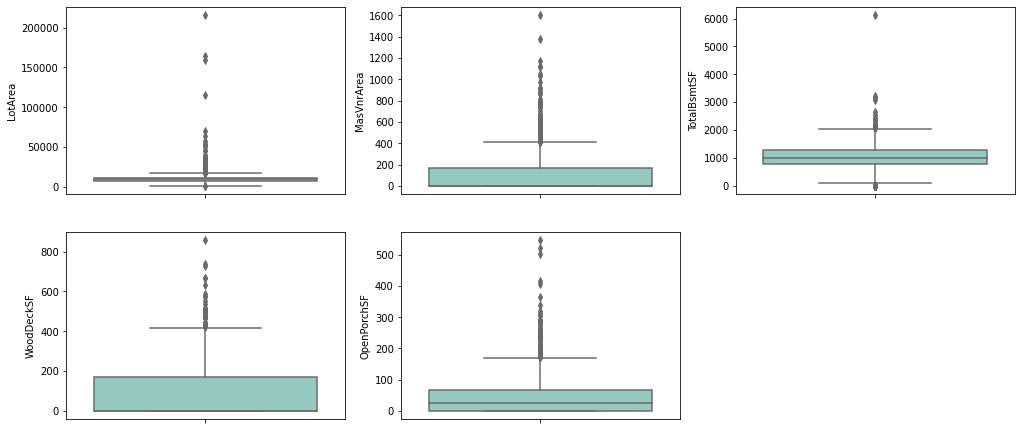

In [199]:
## Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='Set3', data = housing)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='Set3', data = housing)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='Set3', data = housing)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='Set3', data = housing)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='Set3', data = housing)
plt.show()

In [200]:
## Removing Outliers

## Removing values beyond 98% for LotArea

nn_quartile_LotArea = housing['LotArea'].quantile(0.98)
housing = housing[housing["LotArea"] < nn_quartile_LotArea]

## Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = housing['MasVnrArea'].quantile(0.98)
housing = housing[housing["MasVnrArea"] < nn_quartile_MasVnrArea]

## Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = housing['TotalBsmtSF'].quantile(0.99)
housing = housing[housing["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

## Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = housing['WoodDeckSF'].quantile(0.99)
housing = housing[housing["WoodDeckSF"] < nn_quartile_WoodDeckSF]

## Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = housing['OpenPorchSF'].quantile(0.99)
housing = housing[housing["OpenPorchSF"] < nn_quartile_OpenPorchSF]

In [201]:
# Determine the percentage of data retained

num_data = round(100*(len(housing)/1460),2)
print(num_data)

93.01


### Step 3: Data Visualization

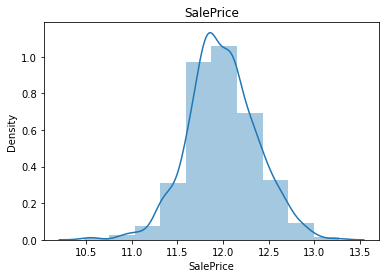

In [202]:
## Visualise the target variable -> SalePrice after transforming the sales price

housing['SalePrice'] = np.log1p(housing['SalePrice'])
plt.title('SalePrice')
sns.distplot(housing['SalePrice'], bins=10)
plt.show()


##### The target value seems to be normalized with some noise.

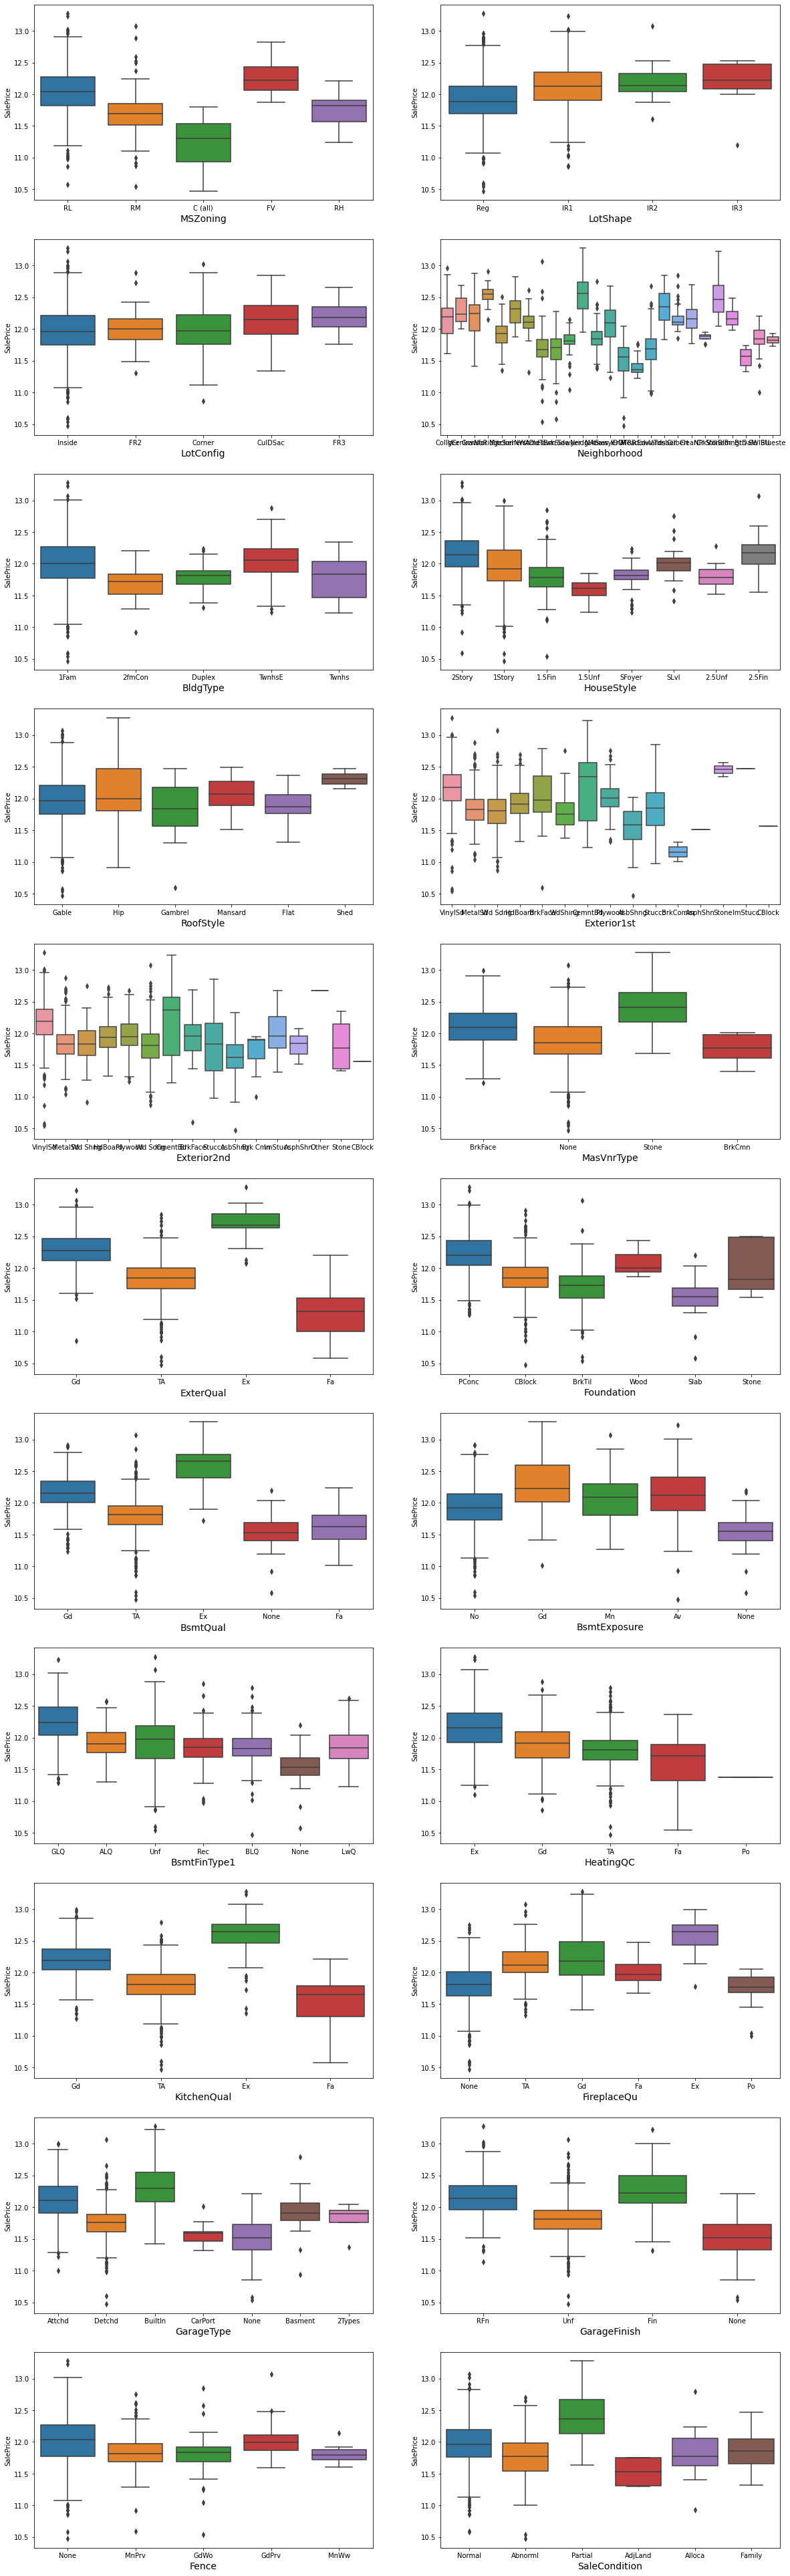

In [203]:
cat_col=list(housing.select_dtypes('object'))
plt.figure(figsize=(20,70))
for m,n in enumerate(cat_col):
    plt.subplot(11,2,(m+1))
    sns.boxplot(x=n, y='SalePrice',data=housing)
    plt.xlabel(n, fontsize=14)
plt.show()

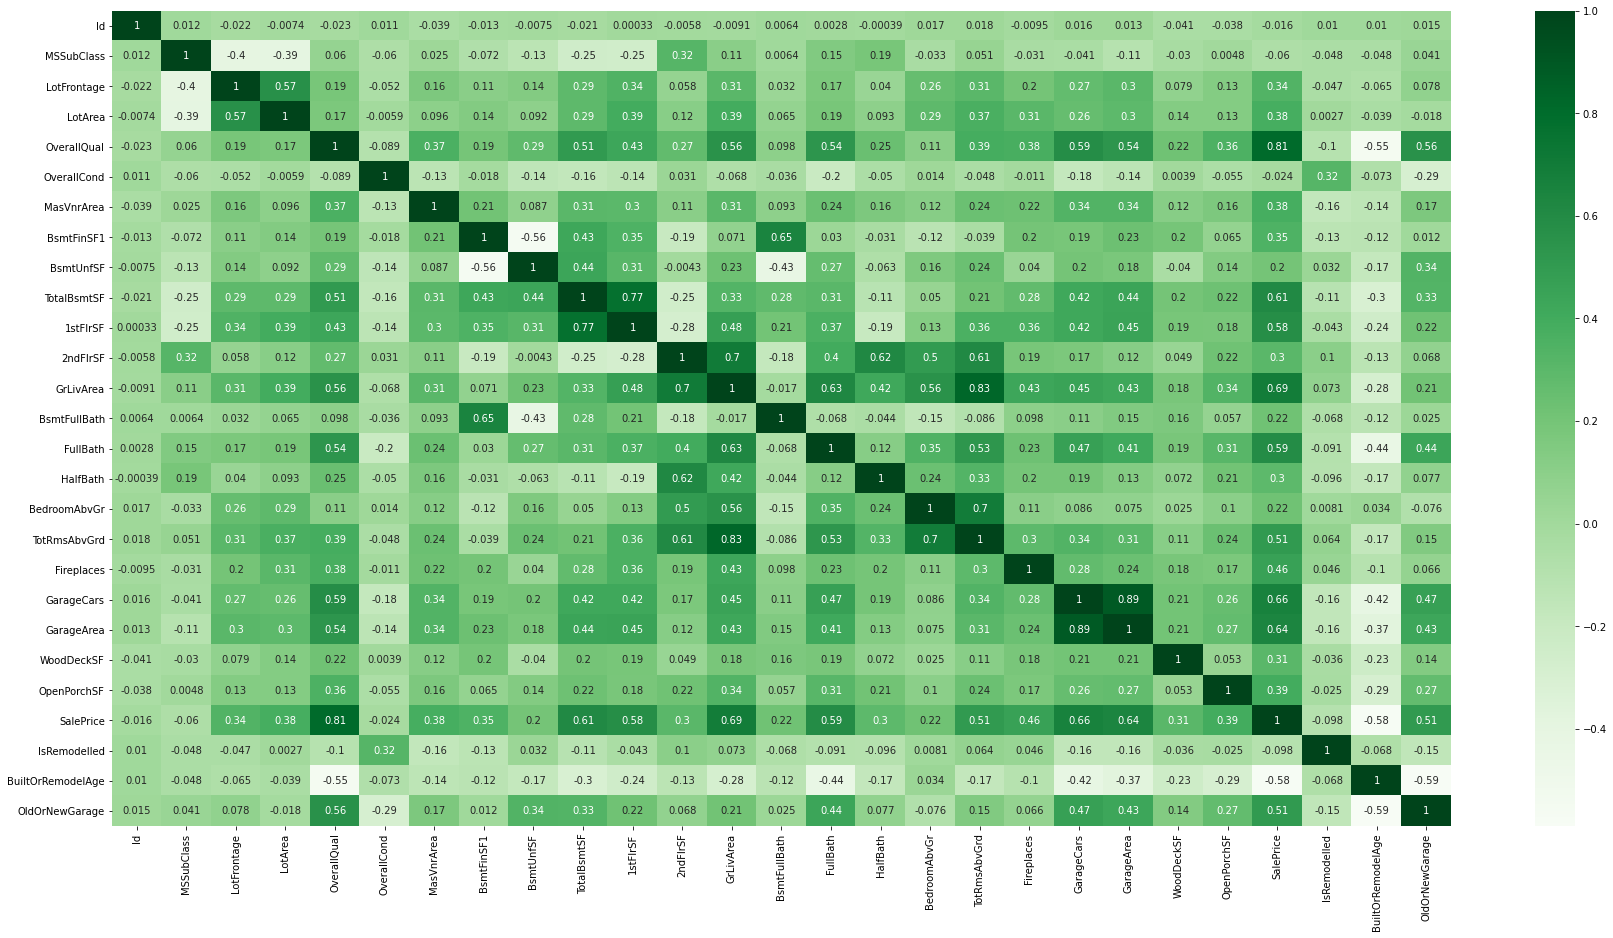

In [204]:
# Check the correlation of numerical columns

plt.figure(figsize = (30, 15))
sns.heatmap(housing.corr(), annot = True, cmap="Greens")
plt.show()

<Figure size 720x360 with 0 Axes>

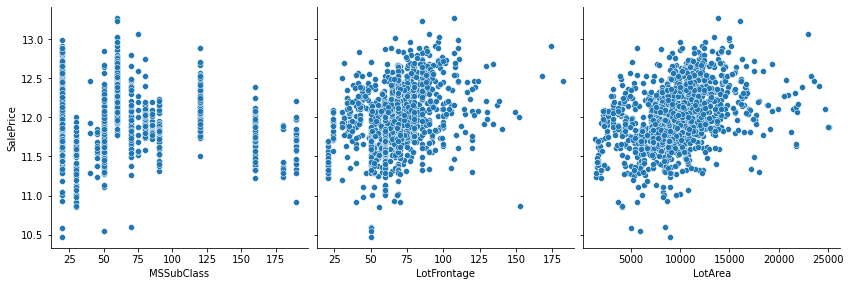

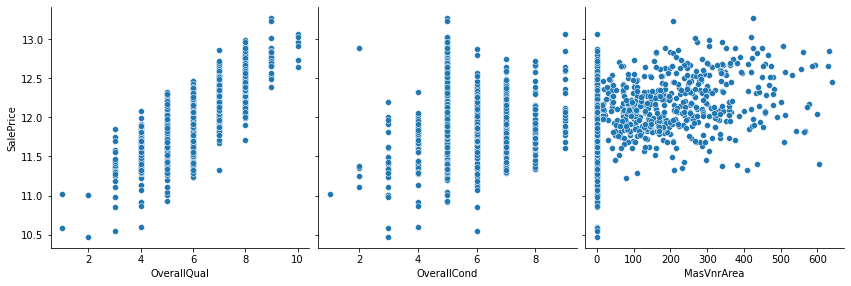

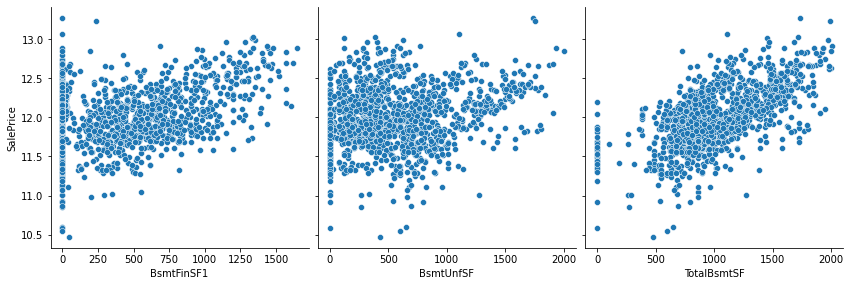

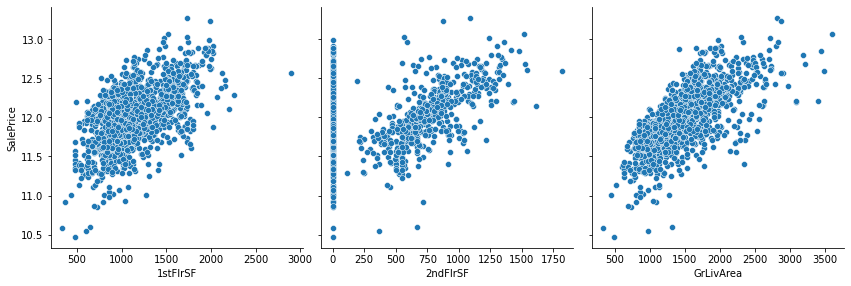

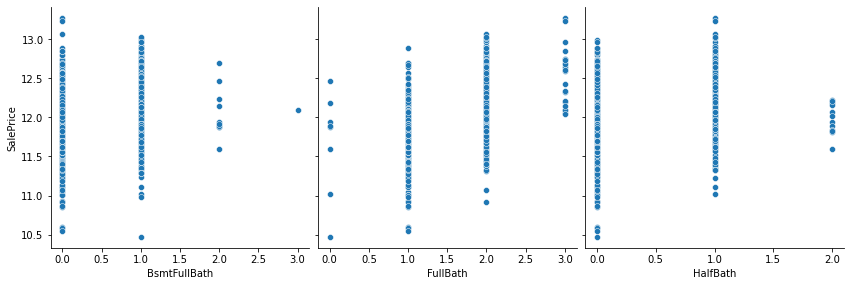

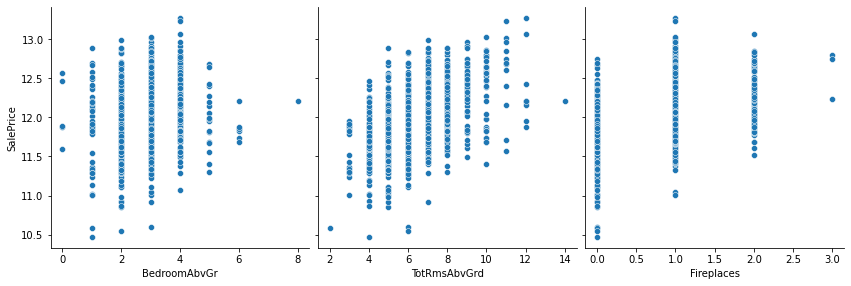

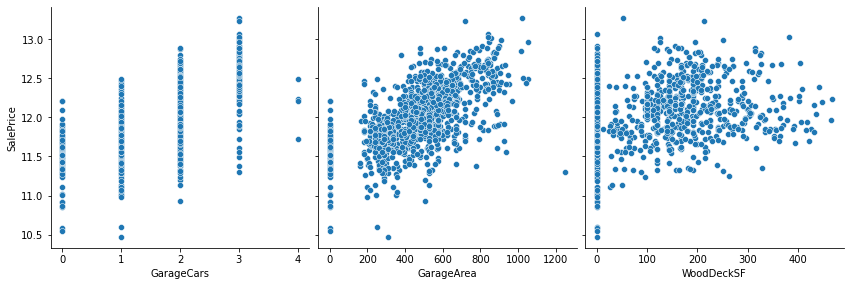

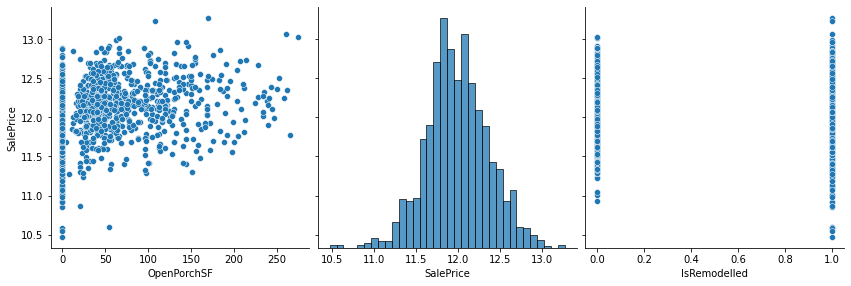

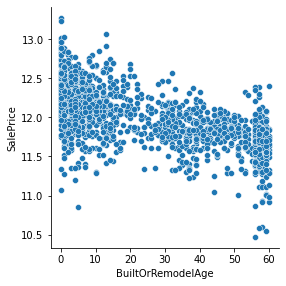

In [205]:
## Check the numerical values using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(housing, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['OpenPorchSF','SalePrice', 'IsRemodelled'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(housing, x_vars=['BuiltOrRemodelAge'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

#### From the above pair plot we can see the observations :

- `1stFlrSF` and `GrLivArea` seems to be showing positive correlation
- Rest of the variables are too scattered and hence can be understood during further analysis

#### From the above heat map we can see that there is a high correlation for 
- TotRmsAbvGrd and GrLivArea show 82%
- Garage Area and Garage Cars show 88%
#### Hence dropping TotRmsAbvGrd and Garage Cars

In [206]:
## Removing the highly correlated variables

housing.drop(['TotRmsAbvGrd', 'GarageArea'], axis = 1, inplace = True)

In [207]:
housing.shape

(1358, 47)

### Step 4: Data Preparation
- Converting categorical data into numercal data
- Creating Dummies

In [208]:
## For values which can be ordered, we have given an ordered sequence value
## For values which cannot be ordered, we have categorised them into 0 and 1

housing['dum_LotShape'] = housing['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
housing['dum_ExterQual'] = housing['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
housing['dum_BsmtQual'] = housing['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housing['dum_BsmtExposure'] = housing['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
housing['dum_BsmtFinType1'] = housing['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
housing['dum_HeatingQC'] = housing['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housing['dum_KitchenQual'] = housing['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housing['dum_FireplaceQu'] = housing['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
housing['dum_GarageFinish'] = housing['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })
housing['dum_BldgType'] = housing['BldgType'].map({'Twnhs': 5, 'TwnhsE': 4, 'Duplex': 3, '2fmCon': 2, '1Fam': 1, 'None': 0 })
housing['dum_HouseStyle'] = housing['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
housing['dum_Fence'] = housing['Fence'].map({'GdPrv': 4, 'GdWo': 3, 'MnPrv': 2, 'MnWw': 1, 'None': 0 })
housing['dum_LotConfig'] = housing['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 'None': 0  })
housing['dum_MasVnrType'] = housing['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
housing['dum_SaleCondition'] = housing['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 'Alloca': 0, 'AdjLand': 0, 'None': 0})
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,dum_LotShape,dum_ExterQual,dum_BsmtQual,dum_BsmtExposure,dum_BsmtFinType1,dum_HeatingQC,dum_KitchenQual,dum_FireplaceQu,dum_GarageFinish,dum_BldgType,dum_HouseStyle,dum_Fence,dum_LotConfig,dum_MasVnrType,dum_SaleCondition
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,0,None,Attchd,RFn,2,0,61,None,Normal,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,1,TA,Attchd,RFn,2,298,0,None,Normal,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,1,TA,Attchd,RFn,2,0,42,None,Normal,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,1,Gd,Detchd,Unf,3,0,35,None,Abnorml,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,1,TA,Attchd,RFn,3,192,84,None,Normal,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1


In [209]:
## drop the old columns from which the new columns were derived
## We can also drop the id column as it will not be used any more

housing = housing.drop(['Id', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'BldgType', 'HouseStyle', 'Fence', 
                                'LotConfig', 'MasVnrType', 'SaleCondition'], axis=1)

housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageType,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,dum_LotShape,dum_ExterQual,dum_BsmtQual,dum_BsmtExposure,dum_BsmtFinType1,dum_HeatingQC,dum_KitchenQual,dum_FireplaceQu,dum_GarageFinish,dum_BldgType,dum_HouseStyle,dum_Fence,dum_LotConfig,dum_MasVnrType,dum_SaleCondition
0,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,196.0,PConc,706,150,856,856,854,1710,1,2,1,3,0,Attchd,2,0,61,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1
1,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,0.0,CBlock,978,284,1262,1262,0,1262,0,2,0,3,1,Attchd,2,298,0,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1
2,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,162.0,PConc,486,434,920,920,866,1786,1,2,1,3,1,Attchd,2,0,42,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1
3,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,0.0,BrkTil,216,540,756,961,756,1717,1,1,0,3,1,Detchd,3,0,35,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0
4,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,350.0,PConc,655,490,1145,1145,1053,2198,1,2,1,4,1,Attchd,3,192,84,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1


In [210]:
## For the following columns create dummies

## Creating dummies for MSZoning

dum_MSZoning = pd.get_dummies(housing['MSZoning'], prefix='MSZoning', drop_first = True)
housing = pd.concat([housing, dum_MSZoning], axis = 1)

## Creating dummies for Neighborhood

dum_Neighborhood = pd.get_dummies(housing['Neighborhood'], prefix='Neighborhood', drop_first = True)
housing = pd.concat([housing, dum_Neighborhood], axis = 1)

## Creating dummies for RoofStyle

dum_RoofStyle = pd.get_dummies(housing['RoofStyle'], prefix='RoofStyle', drop_first = True)
housing = pd.concat([housing, dum_RoofStyle], axis = 1)

## Creating dummies for Exterior1st

dum_Exterior1st = pd.get_dummies(housing['Exterior1st'], prefix='Exterior1st', drop_first = True)
housing = pd.concat([housing, dum_Exterior1st], axis = 1)

## Creating dummies for Exterior2nd

dum_Exterior2nd = pd.get_dummies(housing['Exterior2nd'], prefix='Exterior2nd', drop_first = True)
housing = pd.concat([housing, dum_Exterior2nd], axis = 1)

## Creating dummies for Foundation

dum_Foundation = pd.get_dummies(housing['Foundation'], prefix='Foundation', drop_first = True)
housing = pd.concat([housing, dum_Foundation], axis = 1)

## Creating dummies for GarageType

dum_GarageType = pd.get_dummies(housing['GarageType'], prefix='GarageType', drop_first = True)
housing = pd.concat([housing, dum_GarageType], axis = 1)

housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrArea,Foundation,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageType,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,dum_LotShape,dum_ExterQual,dum_BsmtQual,dum_BsmtExposure,dum_BsmtFinType1,dum_HeatingQC,dum_KitchenQual,dum_FireplaceQu,dum_GarageFinish,...,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,196.0,PConc,706,150,856,856,854,1710,1,2,1,3,0,Attchd,2,0,61,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,0.0,CBlock,978,284,1262,1262,0,1262,0,2,0,3,1,Attchd,2,298,0,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,162.0,PConc,486,434,920,920,866,1786,1,2,1,3,1,Attchd,2,0,42,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,0.0,BrkTil,216,540,756,961,756,1717,1,1,0,3,1,Detchd,3,0,35,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,350.0,PConc,655,490,1145,1145,1053,2198,1,2,1,4,1,Attchd,3,192,84,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [211]:
## Drop the below columns as we now have new columns derived from these columns

housing = housing.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                                'GarageType'], axis=1)

housing.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,dum_LotShape,dum_ExterQual,dum_BsmtQual,dum_BsmtExposure,dum_BsmtFinType1,dum_HeatingQC,dum_KitchenQual,dum_FireplaceQu,dum_GarageFinish,dum_BldgType,dum_HouseStyle,dum_Fence,dum_LotConfig,dum_MasVnrType,dum_SaleCondition,MSZoning_FV,...,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,65.0,8450,7,5,196.0,706,150,856,856,854,1710,1,2,1,3,0,2,0,61,12.247699,0,5,1,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,80.0,9600,6,8,0.0,978,284,1262,1262,0,1262,0,2,0,3,1,2,298,0,12.109016,0,31,0,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,68.0,11250,7,5,162.0,486,434,920,920,866,1786,1,2,1,3,1,2,0,42,12.317171,1,6,1,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,60.0,9550,7,5,0.0,216,540,756,961,756,1717,1,1,0,3,1,3,0,35,11.849405,1,36,0,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,84.0,14260,8,5,350.0,655,490,1145,1145,1053,2198,1,2,1,4,1,3,192,84,12.429220,0,8,1,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [212]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Columns: 112 entries, MSSubClass to GarageType_None
dtypes: float64(3), int64(36), uint8(73)
memory usage: 561.2 KB


### Step 5: Train Test Split

In [213]:
## Dropping off the targent variable from X

X = housing.drop(['SalePrice'], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage,dum_LotShape,dum_ExterQual,dum_BsmtQual,dum_BsmtExposure,dum_BsmtFinType1,dum_HeatingQC,dum_KitchenQual,dum_FireplaceQu,dum_GarageFinish,dum_BldgType,dum_HouseStyle,dum_Fence,dum_LotConfig,dum_MasVnrType,dum_SaleCondition,MSZoning_FV,MSZoning_RH,...,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,65.0,8450,7,5,196.0,706,150,856,856,854,1710,1,2,1,3,0,2,0,61,0,5,1,3,4,4,1,6,5,4,0,2,1,4,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,20,80.0,9600,6,8,0.0,978,284,1262,1262,0,1262,0,2,0,3,1,2,298,0,0,31,0,3,3,4,4,5,5,3,3,2,1,1,0,2,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,60,68.0,11250,7,5,162.0,486,434,920,920,866,1786,1,2,1,3,1,2,0,42,1,6,1,2,4,4,2,6,5,4,3,2,1,4,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,70,60.0,9550,7,5,0.0,216,540,756,961,756,1717,1,1,0,3,1,3,0,35,1,36,0,2,3,3,1,5,4,4,4,1,1,4,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,60,84.0,14260,8,5,350.0,655,490,1145,1145,1053,2198,1,2,1,4,1,3,192,84,0,8,1,2,4,4,3,6,5,4,3,2,1,4,0,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


In [214]:
## Keeping the target variable in y

y = housing['SalePrice']
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [215]:
## scaling the features
## storing column names in cols
## scaling (the dataframe is converted to a numpy array)

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageType_None'],
      dtype='object', length=111)

In [216]:
## split the data into train and test

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

### Step 5: Recursive feature elimination (RFE)

In [217]:
## Running RFE with the output number of the variable equal to 50

lm = LinearRegression()
lm.fit(X_train, y_train)

## running RFE
rfe = RFE(lm, 50)            
rfe = rfe.fit(X_train, y_train)

In [218]:
## Assign the columns selected by RFE to cols

col = X_train.columns[rfe.support_]

## Assign the 50 features selected using RFE to a dataframe

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df

,Variable,rfe_support,rfe_ranking
0,LotArea,True,1
1,OverallQual,True,1
2,OverallCond,True,1
3,BsmtFinSF1,True,1
4,TotalBsmtSF,True,1
5,1stFlrSF,True,1
6,2ndFlrSF,True,1
7,GrLivArea,True,1
8,BsmtFullBath,True,1
9,FullBath,True,1


In [219]:
## Assign the 50 columns to X_train_rfe

X_train_rfe = X_train[col]

In [220]:
## Associate the new 50 columns to X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

### Step 6: Model Building and Evaluation

In [221]:
## Ridge

# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [222]:
## Display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
16,5,-0.077858,-0.083995,1
17,6,-0.077911,-0.084008,2
18,7,-0.077960,-0.084023,3
15,4,-0.077810,-0.084028,4
19,8,-0.078009,-0.084038,5
20,9,-0.078055,-0.084054,6
21,10,-0.078096,-0.084068,7
14,3,-0.077763,-0.084105,8
22,20,-0.078414,-0.084171,9
13,2,-0.077718,-0.084206,10


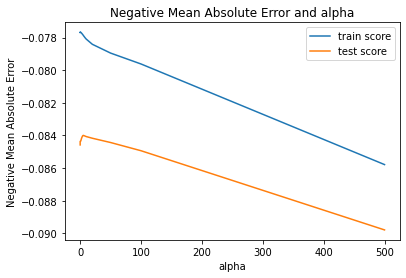

In [223]:
## plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [224]:
## Get the best estimator for lambda

ridge_model_cv.best_estimator_

Ridge(alpha=5.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [225]:
## check the coefficient values

alpha = 5
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 0.02244198,  0.06859185,  0.04618573,  0.03242458,  0.04464796,
        0.01532592,  0.00985187,  0.08705043,  0.01173237,  0.01224633,
        0.02064679,  0.02113356,  0.03650477,  0.01013136, -0.01232161,
       -0.01749244,  0.01377259,  0.01446551,  0.01603191,  0.01847855,
        0.01649622,  0.01500834, -0.02007079,  0.01463695,  0.06802661,
        0.02731043,  0.10504997,  0.07645522,  0.02578389, -0.0112971 ,
       -0.00812036, -0.00658859,  0.02281546, -0.01556288, -0.00956514,
        0.017402  , -0.00942579, -0.01350217,  0.01231639, -0.04085293,
       -0.03196867,  0.01219062, -0.01680706,  0.03557507,  0.02069669,
        0.02222556,  0.04299123,  0.01730159,  0.00695619, -0.00968378])

In [226]:
## Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

0.013714006883317444

In [227]:
## Keep the Features and coefficients in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

,Features,Coefficient
0,LotArea,0.0224
1,OverallQual,0.0686
2,OverallCond,0.0462
3,BsmtFinSF1,0.0324
4,TotalBsmtSF,0.0446
5,1stFlrSF,0.0153
6,2ndFlrSF,0.0099
7,GrLivArea,0.0871
8,BsmtFullBath,0.0117
9,FullBath,0.0122


In [228]:
## Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict

{'1stFlrSF': 0.0153,
 '2ndFlrSF': 0.0099,
 'BsmtFinSF1': 0.0324,
 'BsmtFullBath': 0.0117,
 'BuiltOrRemodelAge': -0.0175,
 'Exterior1st_BrkComm': -0.0094,
 'Exterior1st_CemntBd': -0.0135,
 'Exterior1st_Stucco': 0.0123,
 'Exterior1st_VinylSd': -0.0409,
 'Exterior1st_Wd Sdng': -0.032,
 'Exterior2nd_CmentBd': 0.0122,
 'Exterior2nd_Stucco': -0.0168,
 'Exterior2nd_VinylSd': 0.0356,
 'Exterior2nd_Wd Sdng': 0.0207,
 'Fireplaces': 0.0211,
 'Foundation_CBlock': 0.0222,
 'Foundation_PConc': 0.043,
 'Foundation_Slab': 0.0173,
 'Foundation_Stone': 0.007,
 'FullBath': 0.0122,
 'GarageCars': 0.0365,
 'GarageType_CarPort': -0.0097,
 'GrLivArea': 0.0871,
 'HalfBath': 0.0206,
 'IsRemodelled': -0.0123,
 'LotArea': 0.0224,
 'MSZoning_FV': 0.068,
 'MSZoning_RH': 0.0273,
 'MSZoning_RL': 0.105,
 'MSZoning_RM': 0.0765,
 'Neighborhood_Crawfor': 0.0258,
 'Neighborhood_Edwards': -0.0113,
 'Neighborhood_MeadowV': -0.0081,
 'Neighborhood_NWAmes': -0.0066,
 'Neighborhood_NridgHt': 0.0228,
 'Neighborhood_OldTown': -

In [229]:
## RFE

## Do an RFE to minimise the features to 15
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

## running RFE
rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_ridge, y_train)

In [230]:
## Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

## Assign top 10 features to a temp dataframe for further display in the bar plot

temp1_df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp1_df = temp1_df.loc[temp1_df['rfe_support'] == True]
temp1_df.reset_index(drop=True, inplace=True)

temp1_df['Coefficient'] = temp1_df['Features'].apply(find)
temp1_df = temp1_df.sort_values(by=['Coefficient'], ascending=False)
temp1_df = temp1_df.head(10)
temp1_df

,Features,rfe_support,rfe_ranking,Coefficient
10,MSZoning_RL,True,1,0.1050
5,GrLivArea,True,1,0.0871
11,MSZoning_RM,True,1,0.0765
1,OverallQual,True,1,0.0686
9,MSZoning_FV,True,1,0.0680
2,OverallCond,True,1,0.0462
4,TotalBsmtSF,True,1,0.0446
14,Foundation_PConc,True,1,0.0430
7,GarageCars,True,1,0.0365
3,BsmtFinSF1,True,1,0.0324


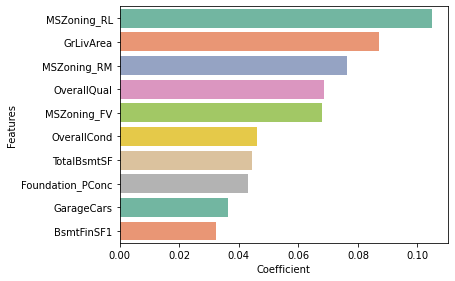

In [231]:
## Bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set2', data = temp1_df)
plt.show()

The above graph displays the top 10 variables based on the Ridge Regression model that are significant in predicting the price of a house.



In [232]:
## Lasso

lasso = Lasso()

## list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

## cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [233]:
## Display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
4,0.0005,-0.078045,-0.084196,1
3,0.0004,-0.077932,-0.084197,2
2,0.0003,-0.077840,-0.084253,3
1,0.0002,-0.077759,-0.084318,4
0,0.0001,-0.077699,-0.084416,5
5,0.001,-0.078700,-0.084681,6
6,0.002,-0.079565,-0.085242,7
7,0.003,-0.080113,-0.085610,8
8,0.004,-0.080610,-0.086044,9
9,0.005,-0.081198,-0.086506,10


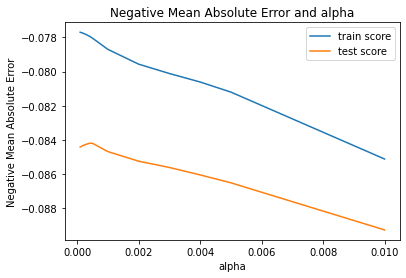

In [234]:
## Plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [235]:
## Get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [236]:
## Check the coefficient values with lambda = 0.0005

alpha = 0.0005

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([ 0.02192174,  0.07091224,  0.04596418,  0.03296041,  0.04524946,
        0.0068201 , -0.        ,  0.09879303,  0.01081883,  0.01036317,
        0.01963504,  0.02111826,  0.03692433,  0.00986284, -0.01208516,
       -0.01794362,  0.01286941,  0.01298041,  0.01598344,  0.01787189,
        0.01627665,  0.01514689, -0.01909375,  0.01472296,  0.06527664,
        0.02524564,  0.10028283,  0.07013572,  0.02498261, -0.01062534,
       -0.00771627, -0.00565968,  0.02152497, -0.01496844, -0.00953415,
        0.01605527, -0.009141  , -0.        ,  0.01078559, -0.02540798,
       -0.02850479,  0.        , -0.01513314,  0.02109609,  0.01675111,
        0.01887004,  0.04045895,  0.01568937,  0.00593085, -0.00915771])

In [237]:
## Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

0.013464242975623389

In [238]:
## Keep the Features and coefficients in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,LotArea,0.0219
1,OverallQual,0.0709
2,OverallCond,0.0460
3,BsmtFinSF1,0.0330
4,TotalBsmtSF,0.0452
5,1stFlrSF,0.0068
6,GrLivArea,0.0988
7,BsmtFullBath,0.0108
8,FullBath,0.0104
9,HalfBath,0.0196


In [239]:
## Keep the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'1stFlrSF': 0.00682009955691738,
 '2ndFlrSF': -0.0,
 'BsmtFinSF1': 0.03296040529512133,
 'BsmtFullBath': 0.010818826810128879,
 'BuiltOrRemodelAge': -0.017943615295401127,
 'Exterior1st_BrkComm': -0.009140999393806273,
 'Exterior1st_CemntBd': -0.0,
 'Exterior1st_Stucco': 0.010785587508781155,
 'Exterior1st_VinylSd': -0.025407976118916913,
 'Exterior1st_Wd Sdng': -0.028504794190014865,
 'Exterior2nd_CmentBd': 0.0,
 'Exterior2nd_Stucco': -0.015133142034830432,
 'Exterior2nd_VinylSd': 0.021096092596517218,
 'Exterior2nd_Wd Sdng': 0.016751113408671477,
 'Fireplaces': 0.021118259861075662,
 'Foundation_CBlock': 0.018870044203808424,
 'Foundation_PConc': 0.040458945397227525,
 'Foundation_Slab': 0.015689372970748947,
 'Foundation_Stone': 0.005930848775593562,
 'FullBath': 0.010363165178013127,
 'GarageCars': 0.03692432712163677,
 'GarageType_CarPort': -0.009157708800397884,
 'GrLivArea': 0.09879302630451335,
 'HalfBath': 0.019635043960786053,
 'IsRemodelled': -0.012085155614514892,
 'LotAre

In [240]:
## Do an RFE to minimise the features to 15

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

## running RFE

rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_lasso, y_train)

In [241]:
## Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]

## Assign top 10 features to a temp dataframe for further display in the bar plot

temp2_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp2_df = temp2_df.loc[temp2_df['rfe_support'] == True]
temp2_df.reset_index(drop=True, inplace=True)

temp2_df['Coefficient'] = temp2_df['Features'].apply(find)
temp2_df = temp2_df.sort_values(by=['Coefficient'], ascending=False)
temp2_df = temp2_df.head(10)
temp2_df

,Features,rfe_support,rfe_ranking,Coefficient
11,MSZoning_RL,True,1,0.100283
5,GrLivArea,True,1,0.098793
1,OverallQual,True,1,0.070912
12,MSZoning_RM,True,1,0.070136
9,MSZoning_FV,True,1,0.065277
2,OverallCond,True,1,0.045964
4,TotalBsmtSF,True,1,0.045249
14,Foundation_PConc,True,1,0.040459
7,GarageCars,True,1,0.036924
3,BsmtFinSF1,True,1,0.032960


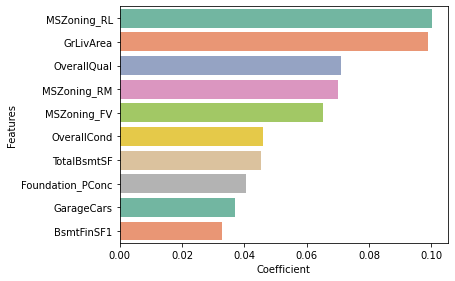

In [242]:
## Bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set2', data = temp2_df)
plt.show()

The above graph displays the top 10 variables based on the Lasso Regression model that are significant in predicting the price of a house.



### Conclusion :
The optimal lambda value in case of Ridge and Lasso are:

- Ridge : 5
- Lasso : 0.0005

The Mean Squared error in case of Ridge and Lasso are:

- Ridge : 0.013714   
- Lasso : 0.013464

The Mean Squared Error of Lasso is slightly lower than that of Ridge

Also, since Lasso helps in feature reduction (as the coefficient value of one of the feature became 0), Lasso has a better edge over Ridge.

Hence based on Lasso, the factors that generally affect the price are the Zoning classification, Living area square feet, Overall quality and condition of the house, Foundation type of the house, Number of cars that can be accomodated in the garage, Total basement area in square feet and the Basement finished square feet area

Therefore, the variables predicted by Lasso in the above bar chart as significant variables for predicting the price of a house.

#### Question 1 (Subjective)

In [243]:
## Ridge Train Score
ridge.score(X_train,y_train)


0.9190735386969244

In [244]:
## Lasso Train Score
lasso.score(X_train,y_train)

0.9186764840131485

In [245]:
alpha = 14 # use the optimal value of alpha obtained from above.
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=14, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [246]:
ridge.score(X_train,y_train)

0.9181134705971198

In [247]:
ridge.score(X_test,y_test)

0.901740433448263

In [248]:
# Link the lasso regression coefficients to the columns
ridge_df = pd.DataFrame(sorted(list(zip(ridge.coef_, X_train.columns))), columns=['Coefficient', 'Column'])

In [249]:
ridge_df.head()


,Coefficient,Column
0,-0.029892,Exterior1st_VinylSd
1,-0.029294,Exterior1st_Wd Sdng
2,-0.019514,dum_BldgType
3,-0.018232,BuiltOrRemodelAge
4,-0.016248,Exterior2nd_Stucco


In [250]:
ridge_df.tail()


,Coefficient,Column
45,0.049590,MSZoning_RM
46,0.052521,MSZoning_FV
47,0.069094,OverallQual
48,0.071025,GrLivArea
49,0.075184,MSZoning_RL


In [251]:
alpha = 0.001 # use the optimal value of alpha obtained from above.
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [252]:
lasso.score(X_train,y_train)


0.9167096064542282

In [253]:
lasso.score(X_test,y_test)


0.9043057966170768

In [254]:
# Link the lasso regression coefficients to the columns
lasso_df = pd.DataFrame(sorted(list(zip(lasso.coef_, X_train.columns))), columns=['Coefficient', 'Column'])

In [255]:
lasso_df.head()


,Coefficient,Column
0,-0.023125,Exterior1st_Wd Sdng
1,-0.019051,BuiltOrRemodelAge
2,-0.017706,dum_BldgType
3,-0.013488,Neighborhood_OldTown
4,-0.012714,IsRemodelled


In [256]:
lasso_df.tail()


,Coefficient,Column
45,0.046287,OverallCond
46,0.046707,MSZoning_FV
47,0.064698,MSZoning_RL
48,0.074400,OverallQual
49,0.097744,GrLivArea


### Question 3 (Subjective)

In [258]:
X_train = X_train.drop(['MSZoning_RL', 'GrLivArea', 'OverallQual', 'MSZoning_RM','MSZoning_FV'], axis=1)


In [259]:
lasso = Lasso()

In [260]:
folds = 5
model_lasso = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       scoring='neg_mean_absolute_error',
                       cv=folds,
                       return_train_score=True,
                       verbose=1)

In [261]:
model_lasso.fit(X_train, y_train)


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [262]:
model_lasso.best_params_


{'alpha': 0.001}

In [263]:
model_lasso.best_score_


-0.09323859424395273

In [264]:
alpha = 0.0002
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [265]:

lasso.coef_

array([ 0.02320372,  0.05395263,  0.03256269,  0.0557843 ,  0.08561319,
        0.10062498,  0.01228187,  0.02154633,  0.02626248,  0.03008135,
        0.03859725,  0.00719023, -0.02038385, -0.02033901,  0.02737095,
        0.02682993,  0.01795047,  0.0208038 ,  0.03015276,  0.01833708,
       -0.01755764,  0.01594649,  0.00240443,  0.02601912, -0.01408283,
       -0.01787181, -0.00605071,  0.02380573, -0.0214312 , -0.00650073,
        0.02008014, -0.00858785, -0.00030553,  0.01808299, -0.05511411,
       -0.02894998,  0.        , -0.02128755,  0.04457297,  0.02124737,
        0.01853377,  0.04653977,  0.02101276,  0.00202636, -0.01517368])

In [266]:
lasso_df = pd.DataFrame(sorted(list(zip(lasso.coef_, X_train.columns))), columns=['Coefficient', 'Column'])


In [269]:
lasso_df.head()


,Coefficient,Column
0,-0.055114,Exterior1st_VinylSd
1,-0.028950,Exterior1st_Wd Sdng
2,-0.021431,Neighborhood_OldTown
3,-0.021288,Exterior2nd_Stucco
4,-0.020384,IsRemodelled


In [270]:
lasso_df.tail()


,Coefficient,Column
40,0.046540,Foundation_PConc
41,0.053953,OverallCond
42,0.055784,TotalBsmtSF
43,0.085613,1stFlrSF
44,0.100625,2ndFlrSF
